# Repetition Code Using Dynamic Circuits

**Qiskit Slack: @quantom & @Michael Healy**

**Github: @taalexander & @mbhealy**

Before running this tutorial make sure you are setup with the [Hello notebook](./01-Hello-World-Dynamic-Circuits.ipynb).

Demonstration of very simple error-correction in the form of a bit-flip code.

<img src="figs/ibm_quantum.png" alt="drawing" style="width:1000px;"/>

In [1]:
import os
from typing import Any, Dict, List, Optional, Union

import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info as qi
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from qiskit import transpile

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Choose a backend

In [2]:
# peekskill reservation for summit
hub = "ibm-q-internal"
group = "performance"
project = "summit-demos"
backend_name = "ibm_peekskill"

hub = "ibm-q-internal"
group = "dev-sys-software"
project = "internal-test"
backend_name = "ibm_wellington"
hgp = f"{hub}/{group}/{project}"

In [3]:
# Instantiate the runtime service and backend
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance=hgp)
backend = service.backend(backend_name, instance=hgp)

In [4]:
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)

### Set some global execution properties for the notebook.

Feel free to adjust these.

In [5]:
shots: int = 1024 # Number of shots to run each circuit for

init_num_resets: int = 3 # Set the number of resets to initialize qubits between circuits
init_delay: float = 0. # Set the initialization idle time for qubits between circuits

sim: bool = False # Set True to simulate our experiments and False to run in hardware
dynamical_decoupling: bool = False # Set True to enable dynamical decoupling

# peekskill favorites
#favourite_qubits: List[int] = [5, 3, 8, 2, 9]
# wellington favorites
favourite_qubits: List[int] = [5, 6, 4, 3, 1, 0, 2]

In [6]:
# Some general helper routines that will be used throughout the notebook

import mapomatic as mm
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit_ibm_runtime import RuntimeJob, IBMBackend

def convert_cycles(time_in_seconds: float, backend: IBMBackend) -> int:
    cycles = time_in_seconds / (backend.configuration().dt)
    return int(cycles + (16 - (cycles % 16)))

def execute(circuits: List[QuantumCircuit], verbose: bool = True, **kwargs) -> RuntimeJob:
    """A helper method to execute circuits with common settings in the notebook.
    
    Args:
        circuits: To execute.
        verbose: Emit execution information.
        sim: Run with simulator instead of hardware. By default reads global variable "sim"
    
    """
    if isinstance(circuits, QuantumCircuit):
        circuits = [circuits]

    if sim:
        return backend_sim.run(circuits, shots=shots, **kwargs)
    else:
    
        job = run_openqasm3(circuits, backend, verbose=False, shots=shots, init_num_resets=init_num_resets, init_delay=init_delay, **kwargs)
        if verbose:
            print(f"Running on qasm3, job id: {job.job_id}")

        return job
    
def calculate_initial_layout(
    circuit: QuantumCircuit, 
    mapomatic: Optional[bool] = None, 
    favourite_qubits: Optional[List[int]] = None, 
    blacklist_qubits: Optional[List[int]] = None
) -> List[int]:
    """Routine to help choose the ideal qubit layout given an input circuit.
    
    Args:
        circuit: To evaluate layout for.
        mapomatic: Use mapomatic to choose ideal qubits, otherwise naievly choose ``favourite_qubits``
        favourite_qubits: A list of favourite qubits to ensure are in the layout
        blacklist_qubits: Qubits that are not allowed in the layout.
    """
    deflated = mm.deflate_circuit(circuit)
    if mapomatic:
        deflated = mm.deflate_circuit(circuit)
        available_layouts = [layout for layout in mm.matching_layouts(deflated, backend.configuration().coupling_map, strict_direction=False) if layout[:len(favourite_qubits)] == favourite_qubits and not set(layout).intersection(set(blacklist_qubits))]
        scores = mm.evaluate_layouts(deflated, available_layouts, backend)
        return scores[0][0]
    
    if favourite_qubits is None:
        favourite_qubits = []
    
    if blacklist_qubits is None:
        blacklist_qubits = []
        
    return (favourite_qubits + list(set(range(backend.num_qubits)) - set(favourite_qubits)))[:deflated.num_qubits]

def apply_dynamical_decoupling(
    circuits: List[QuantumCircuit], 
    backend: IBMBackend, 
    initial_layout: List[int],
) -> List[QuantumCircuit]:
    """Apply dynamic circuit dynamical decoupling."""

    from qiskit_ibm_provider.transpiler.passes.scheduling import DynamicCircuitScheduleAnalysis, PadDynamicalDecoupling
    dd_sequence = [XGate(), XGate()]
    durations = InstructionDurations.from_backend(backend)
    pm = PassManager(
        [
            DynamicCircuitScheduleAnalysis(durations),
            PadDynamicalDecoupling(durations, dd_sequence, qubits=initial_layout),
        ]
    )
    return pm.run(circuits)

def apply_transpile(
    circuits: List[QuantumCircuit], 
    backend: IBMBackend, 
    initial_layout: List[int], 
    dynamical_decoupling: bool = dynamical_decoupling, 
    **transpile_kwargs,
) -> List[QuantumCircuit]:
    """Fixed transpile routine to be used for consistency throughout the notebook."""

    transpiled_circuits = transpile(circuits, backend, initial_layout=initial_layout, optimization_level=3, **transpile_kwargs)
    if dynamical_decoupling:
        return apply_dynamical_decoupling(transpiled_circuits, backend, initial_layout)
    return transpiled_circuits

## Executing the bit-flip code on hardware

The bit-flip code is among the simplest examples of a stabilizer code. It can protect our state against a single bit-flip (X) error on any of the encoding qubits. if we consider the action of bit-flip error $X$ which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |0\rangle$ on any of our qubits we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$. The code requires five-qubits, three of which are used to encode the protected state and the remaining two which are used as stabilizer measurement ancillas. Nonetheless, the ancillas are not counted so this means our coding rate for this state is $1/3$.

In [7]:
# Setup a base quantum circuit for our experiments
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc() -> QuantumCircuit:
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

### Initialize our qubit
To protect a quantum state we must first prepare it!
In general we can prepare the state $$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$
In the circuit below we prepare the physical state $$|\Psi_1\rangle = |1\rangle$$

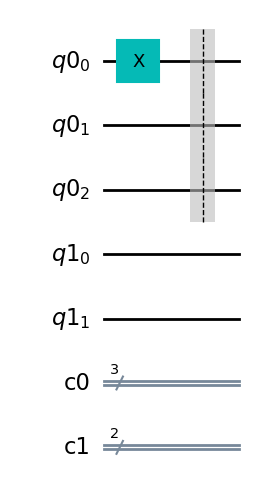

In [8]:
qc_init = build_qc()

qc_init.x(qreg_data[0])
qc_init.barrier(qreg_data)

qc_init.draw(output="mpl")

### Encode our logical state
To protect our qubit we must encode it in the codespace. For the case of the bit-flip code this
is very similar to the repetition code, where we implement repetition using the entangling
`CX` gate rather than a classically conditioned bit-flip as we would do in the classical case.

The encoding circuit below will map $|\Psi_1\rangle = U_{en}|\Psi_0\rangle = |00\rangle (\alpha |000\rangle + \beta |111\rangle)$

The codespace of our bitflip code is therefore $V_s = \{|000\rangle, |111\rangle\}$.

The stabilizers for the bit flip code is $S = III, IZZ, ZIZ, ZZI$. 


Operationally what this means is that
a single bit-flip error applied to the qubits will modify the observed state of a stabilizer measurement but leave it within the codespace. It is also straightforward to show that any two non-trivial Stabilizer elements can generate the full stabilizer. For example taking the generator set $G_0 = \{g_0, g_1 \} = \{ IZZ, ZIZ \}$

We can see this as $g_0g_1 = IZZ . ZIZ = ZZI$ and $g_0g_0 = IZZ.IZZ = III$ completing our Stabilizer.

This means that we must only measure our two generators $g_0$ and $g_1$ to detect any *correctable* error.

It is easy to see the prepared state is a +1 eigenstate of our stabilizers
$IZZ |\Psi_1\rangle = |\Psi_1\rangle$ 
$ZIZ |\Psi_2\rangle = |\Psi_2\rangle$ 

This is because the Stabilizer measures the *parity* of the two target qubits.


The circuit below maps
$$|\Psi_1\rangle \rightarrow |\tilde{\Psi}_1\rangle$$

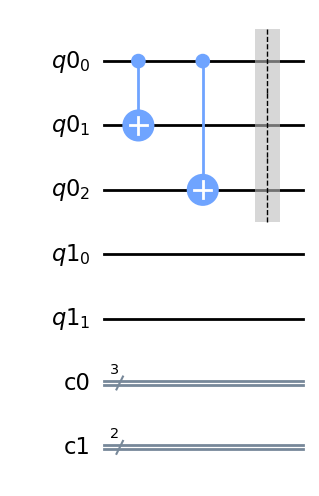

In [9]:
def encode_bit_flip(qc, state, ancillas):
    control = state
    for ancilla in ancillas:
        qc.cx(control, ancilla)
    qc.barrier(state, *ancillas)
    return qc

qc_encode_bit = build_qc()

encode_bit_flip(qc_encode_bit, state_data, ancillas_data)

qc_encode_bit.draw(output="mpl")

### Prepare a decoding circuit
To readout our final state we must map it back from the codespace to a single qubit.
For our code this is simply $U_{de} = U_{en}^\dagger$.

This will be used to map our state out of the codespace
$$|\tilde{\Psi_1}\rangle \rightarrow |\Psi_1\rangle$$

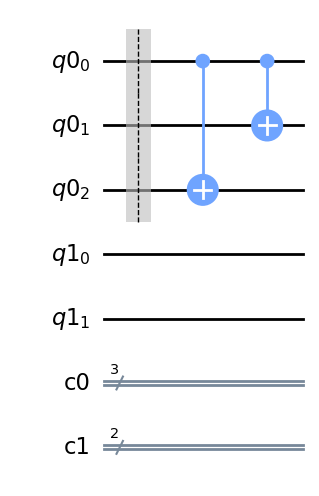

In [10]:
def decode_bit_flip(qc, state, ancillas):
    inv = qc_encode_bit.inverse()
    return qc.compose(inv)

qc_decode_bit = build_qc()

qc_decode_bit = decode_bit_flip(qc_decode_bit, state_data, ancillas_data)

qc_decode_bit.draw(output="mpl")

### A circuit that prepares our encoded state $|\tilde{\Psi}_1\rangle$

Below we see how we can combine the state preparation and encoding steps
to encode our state in the bit-flip code.

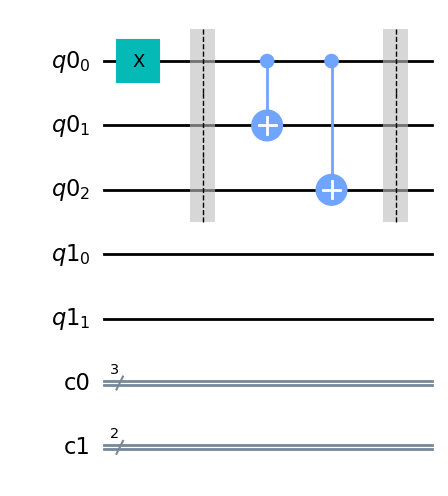

In [11]:
qc_encoded_state_bit = qc_init.compose(qc_encode_bit)
qc_encoded_state_bit.draw(output="mpl")

### Measuring the syndome

If we consider the action of bit-flip error $X$ which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle -> |0\rangle$ on any of our qubits we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$ 

The circuit below measures the stabilizer $IZZ$ onto `creg_measure[0]` and $ZIZ$ onto `creg_measure[1]`. This effectively measures the parity of the two respective qubits in each stabilizer. 

- If we observe `IZZ= -1` an error ocurred on qubit 0 or 1
- If we observe `ZIZ= -1` an error ocurred on qubit 0 or 2

One important detail to note in the circuit below is that we *reset* our ancilla qubits after measuring the stabilizer. This is done so that we may reuse them for repeated stabilizer measurements. Also note we are making
use of the fact that we have already observed the state of the qubit and writing the conditional reset protocol
directly to avoid another round of qubit measurement if we used the `reset` instruction.

The circuit below will measure our Stabilizers generating a syndrome. We assume it is applied after some error channel $\Omega$ which takes $\Omega(|\tilde{\Psi_1}\rangle \langle\tilde{\Psi_1}|) = |\tilde{\Psi_2}\rangle \langle\tilde{\Psi_2}|$.
$$\langle \tilde{\Psi}_2|g_0\cdots g_n|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_2\rangle,\ \  \vec{x}$$

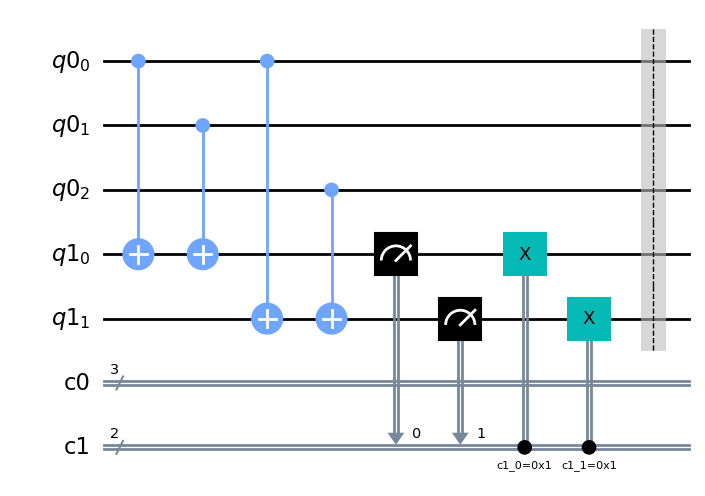

In [12]:
def measure_syndrome_bit(qc, qreg_data, qreg_measure, creg_measure):
    qc.cx(qreg_data[0], qreg_measure[0])
    qc.cx(qreg_data[1], qreg_measure[0])
    qc.cx(qreg_data[0], qreg_measure[1])
    qc.cx(qreg_data[2], qreg_measure[1])
    qc.measure(qreg_measure, creg_measure)
    qc.x(qreg_measure[0]).c_if(creg_measure[0], 1)
    qc.x(qreg_measure[1]).c_if(creg_measure[1], 1)
    qc.barrier(*qreg_data, *qreg_measure)
    return qc

qc_syndrome_bit = measure_syndrome_bit(build_qc(), qreg_data, qreg_measure, creg_syndrome)
qc_syndrome_bit.draw(output="mpl")    

### Visualize the syndrome measurement

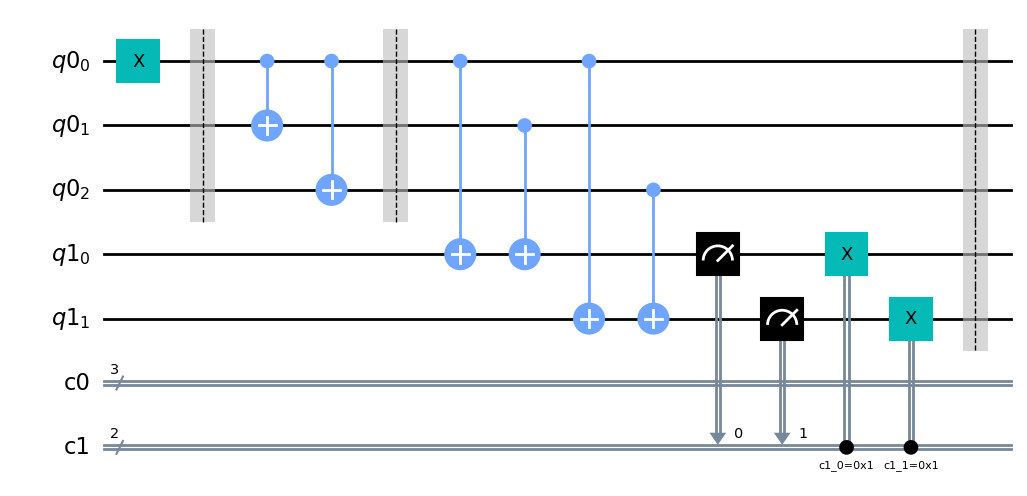

In [13]:
qc_measure_syndrome_bit = qc_encoded_state_bit.compose(qc_syndrome_bit)
qc_measure_syndrome_bit.draw(output="mpl")

## Decoding and applying our correction sequence

Collectively measuring the stabilizers this is enough information to identify where a single X-flip error ocurred.
- If we measure `IZZ=-1` and `ZIZ=1` the error ocurred on qubit 1
- If we measure `IZZ=1` and `ZIZ=-1` the error ocurred on qubit 2
- If we measure `IZZ=-1` and `ZIZ=-1` the error ocurred on qubit 0

The circuit below corrects our state in the case of a single bit-flip error $$|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_1\rangle$$ 

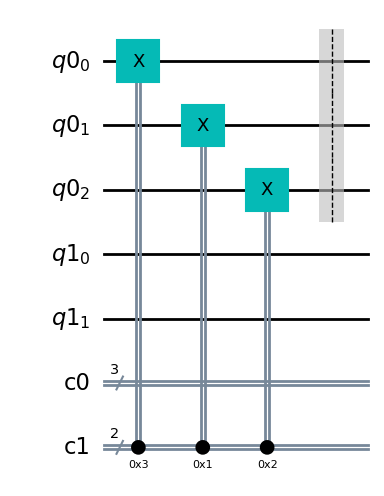

In [14]:
def apply_correction_bit(qc, qreg_data, creg_syndrome):
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc
    
qc_correction_bit = apply_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_correction_bit.draw(output="mpl")

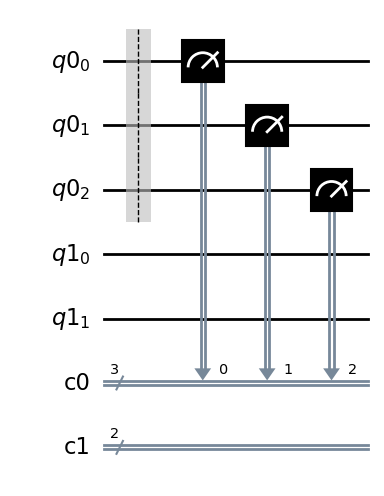

In [15]:
def apply_final_readout(qc, qreg_data, creg_data):
    """Apply inverse mapping so that we always try and measure |1> in the computational basis.
    
    TODO: The above is just a stand in for proper measurement basis measurement
    """
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc

qc_final_measure = apply_final_readout(build_qc(), qreg_data, creg_data)
qc_final_measure.draw(output="mpl")

## Below we see a complete cycle of the bit-flip code
We complete putting our building blocks together in the circuit below

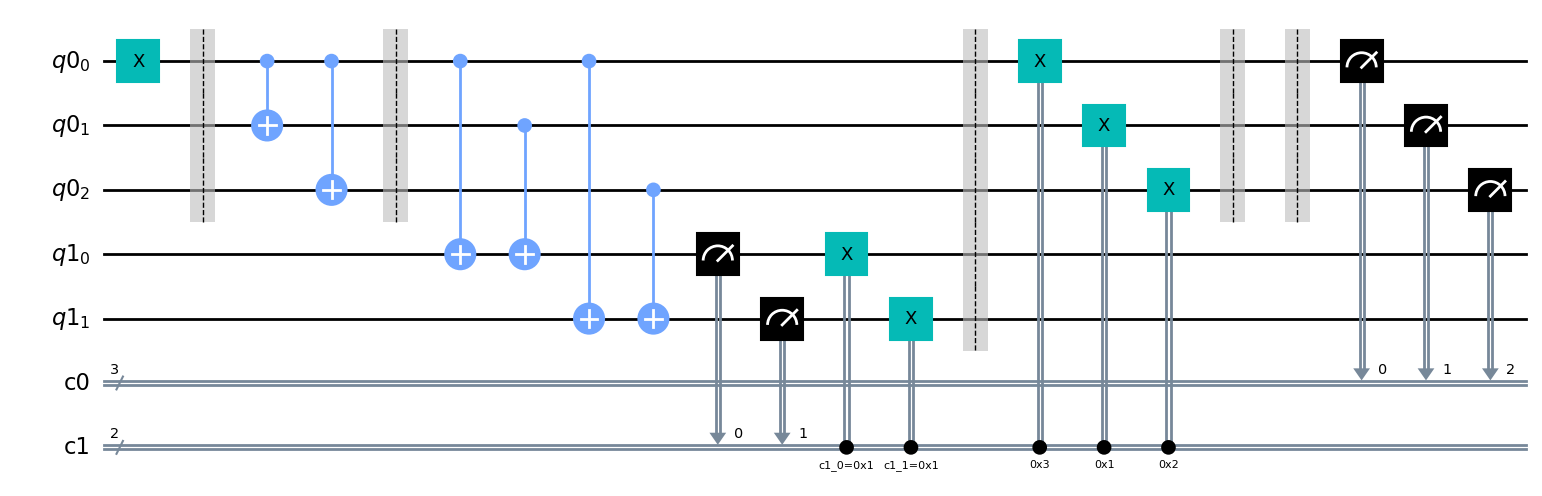

In [16]:
bit_code_circuit = qc_measure_syndrome_bit.compose(qc_correction_bit).compose(qc_final_measure)
bit_code_circuit.draw(output="mpl")

## A routine to perform multiple cycles of parity checks
The routine below will allow us to easily compose multiple cycles of our code interspersed
by the error channels provided in `qc_channels`.

In [17]:
def build_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit], 
    qc_encode: QuantumCircuit, 
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    name=None,
) -> QuantumCircuit:
    """Build a typical error correction circuit"""
    qc = qc_base
    
    if qc_init:
        qc = qc.compose(
            qc_init
        )
    
    qc = qc.compose(
            qc_encode
        )
    if name is not None:
        qc.name = name
    
    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]
        
    for qc_channel in qc_channels:
        qc = qc.compose(
                qc_channel
            ).compose(
                qc_syndrome
            ).compose(
                qc_correct
            )
    if qc_decode:
        qc = qc.compose(qc_decode)
    
    if qc_final:
        qc = qc.compose(qc_final)
    
    return qc

### For example

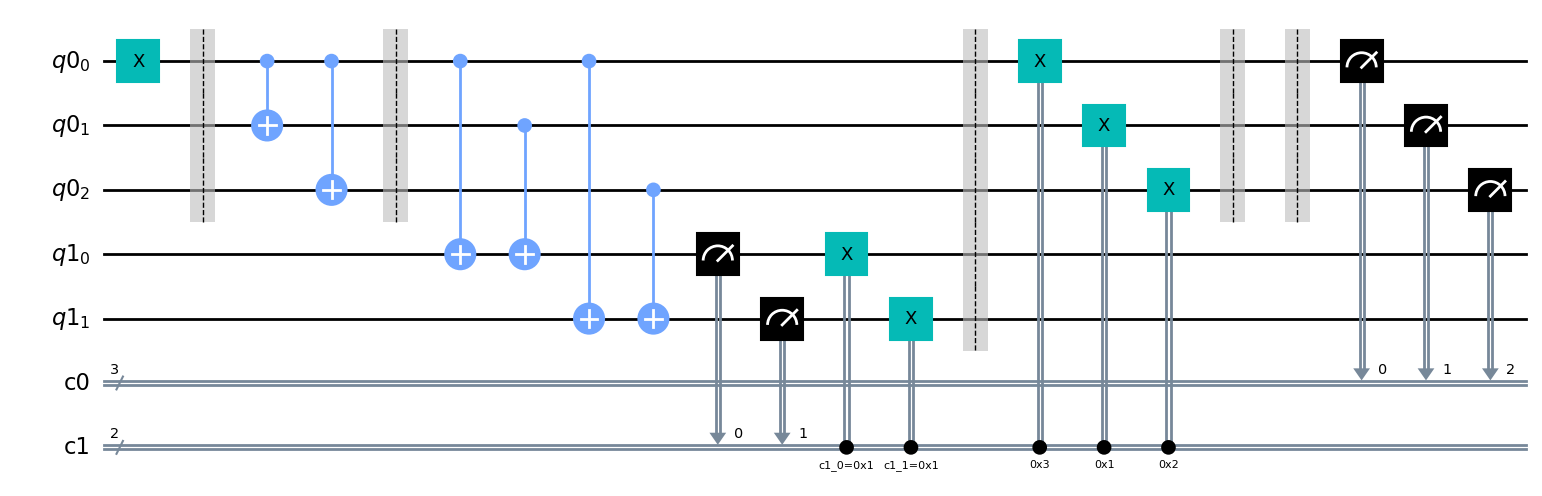

In [18]:
bit_code_circuit = build_error_correction_sequence(
    build_qc(),
    qc_init,
    qc_encode_bit,
    [],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
)
bit_code_circuit.draw(output="mpl")

## Running on Hardware

We now will choose a qubit layout on the device and transpile our abstract circuit to a realizeable
circuit on the device. We will see that due to limited connectivity we will have to perform
qubit routing. As not all qubits are created equal it is important to choose good sets of qubits
in the hardware.

In [19]:
layout_circuit = transpile(bit_code_circuit, backend, optimization_level=3)
print(initial_layout := calculate_initial_layout(layout_circuit, False, favourite_qubits))

[5, 6, 4, 3, 1]


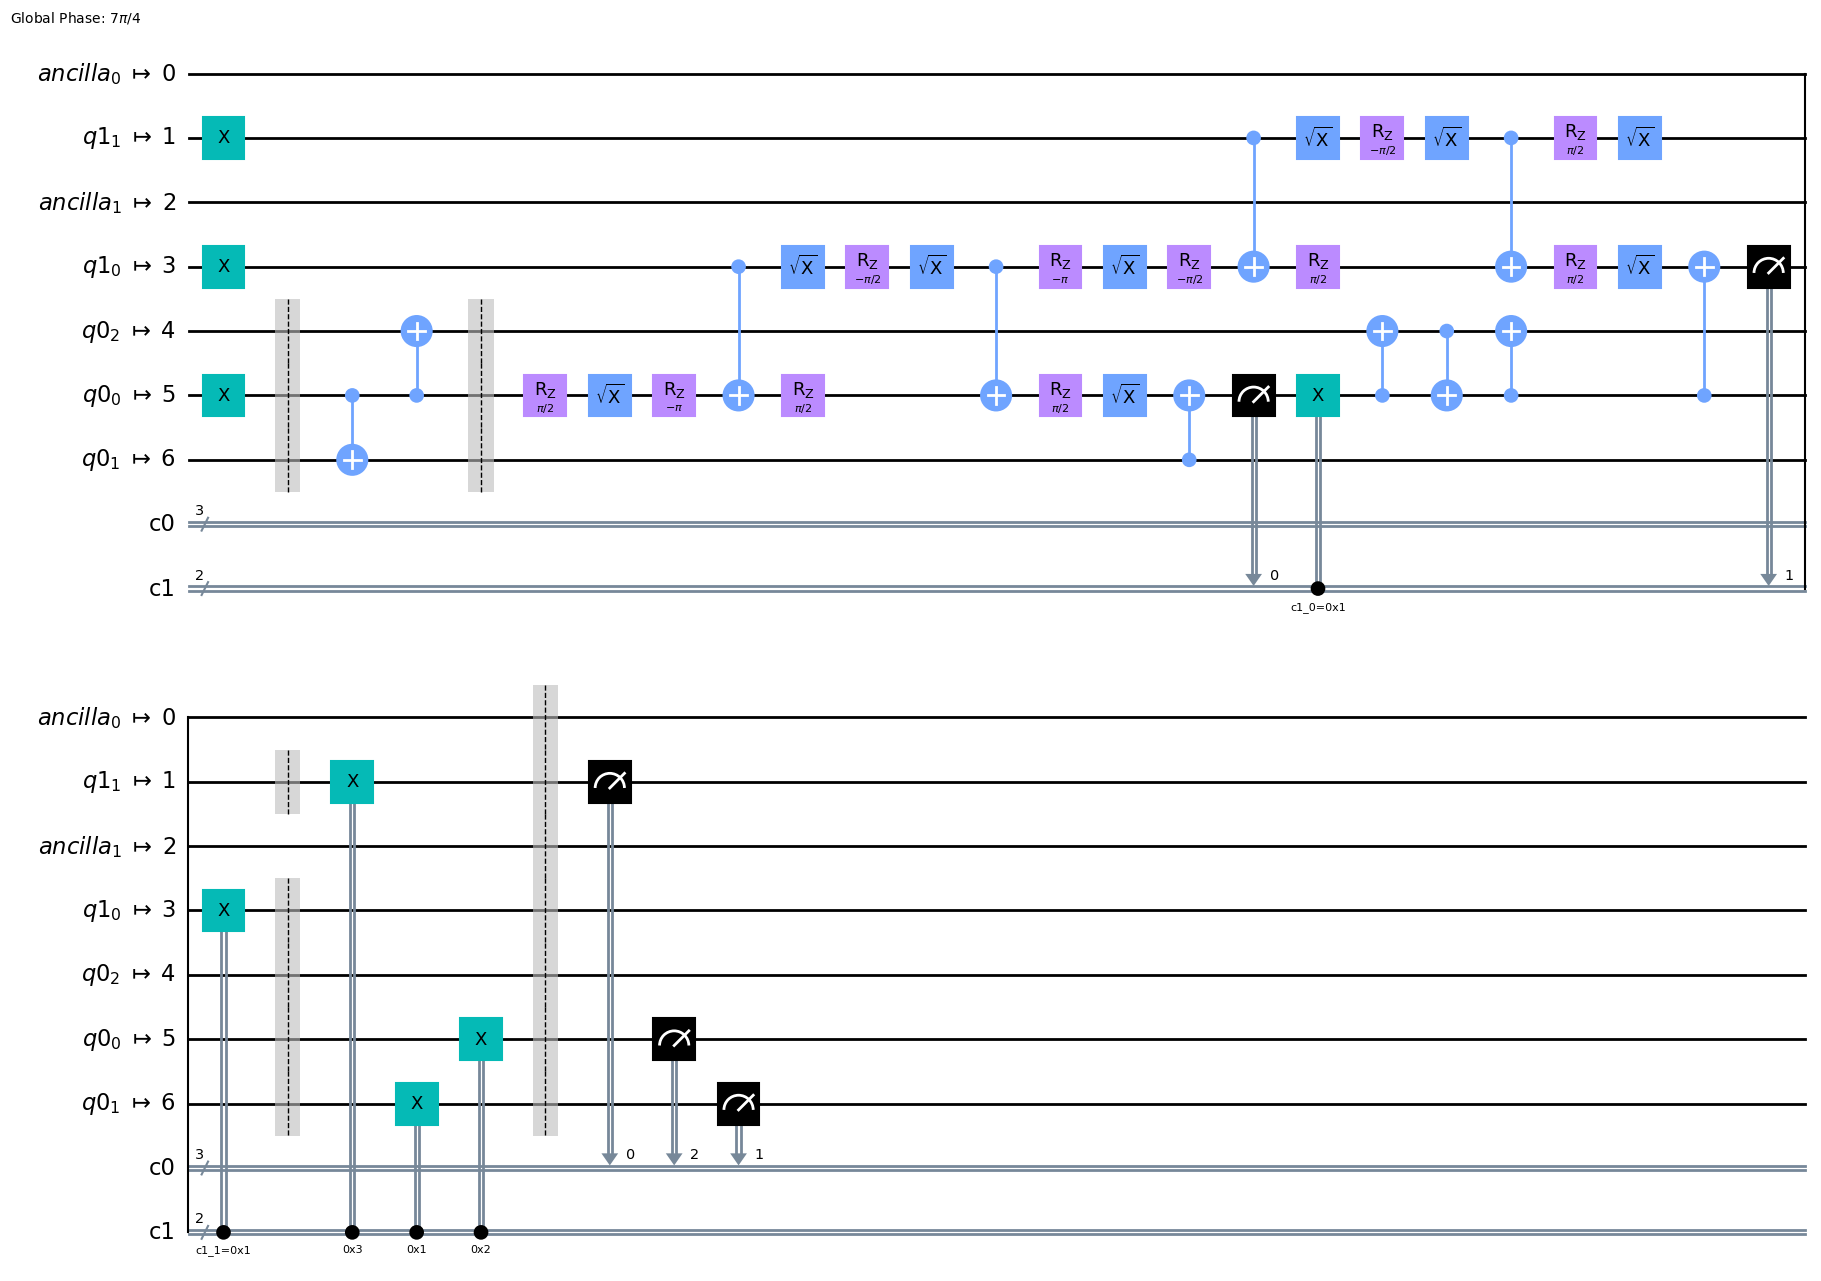

In [20]:
transpiled_bit_code_circuit = apply_transpile(bit_code_circuit, backend, initial_layout=initial_layout)
transpiled_bit_code_circuit.draw(output="mpl")

## Execute the circuit in hardware
Below we execute the circuit in the hadware and then decode the execution results.

In [22]:
result = backend.run(transpiled_bit_code_circuit, dynamic=True).result()

In [23]:
from qiskit.result import marginal_counts

def decode_result(data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots-success_trials
    error_correction_events = shots-syndrome_counts.get('00', 0)
    
    if verbose:
        print(f"{' ' * indent}Bit flip errors were corrected on {error_correction_events}/{shots} trials")
        print(f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials")
        print(f"{' ' * indent}No error was detected on {success_trials}/{shots} trials")
    return error_correction_events, failed_trials

data_indices = list(range(len(qreg_data)))
syndrome_indices = list(range(data_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))
                    
marginalized_data_result = marginal_counts(result, data_indices)
marginalized_syndrome_result = marginal_counts(result, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {marginalized_syndrome_result.get_counts(0)}')
decode_result(marginalized_data_result.get_counts(0), marginalized_syndrome_result.get_counts(0));

Completed bit code experiment data measurement counts {'000': 143, '001': 39, '010': 748, '011': 268, '100': 526, '101': 125, '110': 1680, '111': 471}
Completed bit code experiment syndrome measurement counts {'00': 1854, '10': 950, '11': 501, '01': 695}
Bit flip errors were corrected on 2146/4000 trials
A final parity error was detected on 3386/4000 trials
No error was detected on 614/4000 trials


## Let's emulate a random error source
Here we will use some more control flow to insert a random bit-flip error by using an ancilla qubit as a source of random bit flips and then look at the performance of our code.

In [24]:
from qiskit.circuit.library import IGate, XGate, ZGate

qreg_error_ancilla = QuantumRegister(1)
creg_error_ancilla = ClassicalRegister(1)

def build_random_error_channel(gate, ancilla, creg_ancilla, error_qubit):
    """Build an error channel that randomly applies a single-qubit gate based on an ancilla qubit measurement result"""
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    qc.barrier(ancilla, error_qubit.register)
    # 50-50 chance of applying a bit-flip
    qc.h(ancilla)
    qc.measure(ancilla, creg_ancilla)
    qc.append(gate, [error_qubit]).c_if(creg_ancilla, 1)
    qc.barrier(ancilla, error_qubit.register)
    return qc

qc_id_error_channel = build_random_error_channel(IGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Identity error channel")
print(qc_id_error_channel.draw(idle_wires=False,output='text',fold=-1))

qc_bit_flip_error_channel = build_random_error_channel(XGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Bit flip error channel")
print(qc_bit_flip_error_channel.draw(idle_wires=False,output='text',fold=-1))

qc_phase_flip_error_channel = build_random_error_channel(ZGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Phase flip error channel")
print(qc_phase_flip_error_channel.draw(idle_wires=False,output='text',fold=-1))

Identity error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ I ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
 q44: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    
Bit flip error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ X ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
 q44: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    
Phase flip error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ Z ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
 q44: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    


## Let us now add our error channel in between our syndrome measurement and decode/correct phase to emulate a source of error

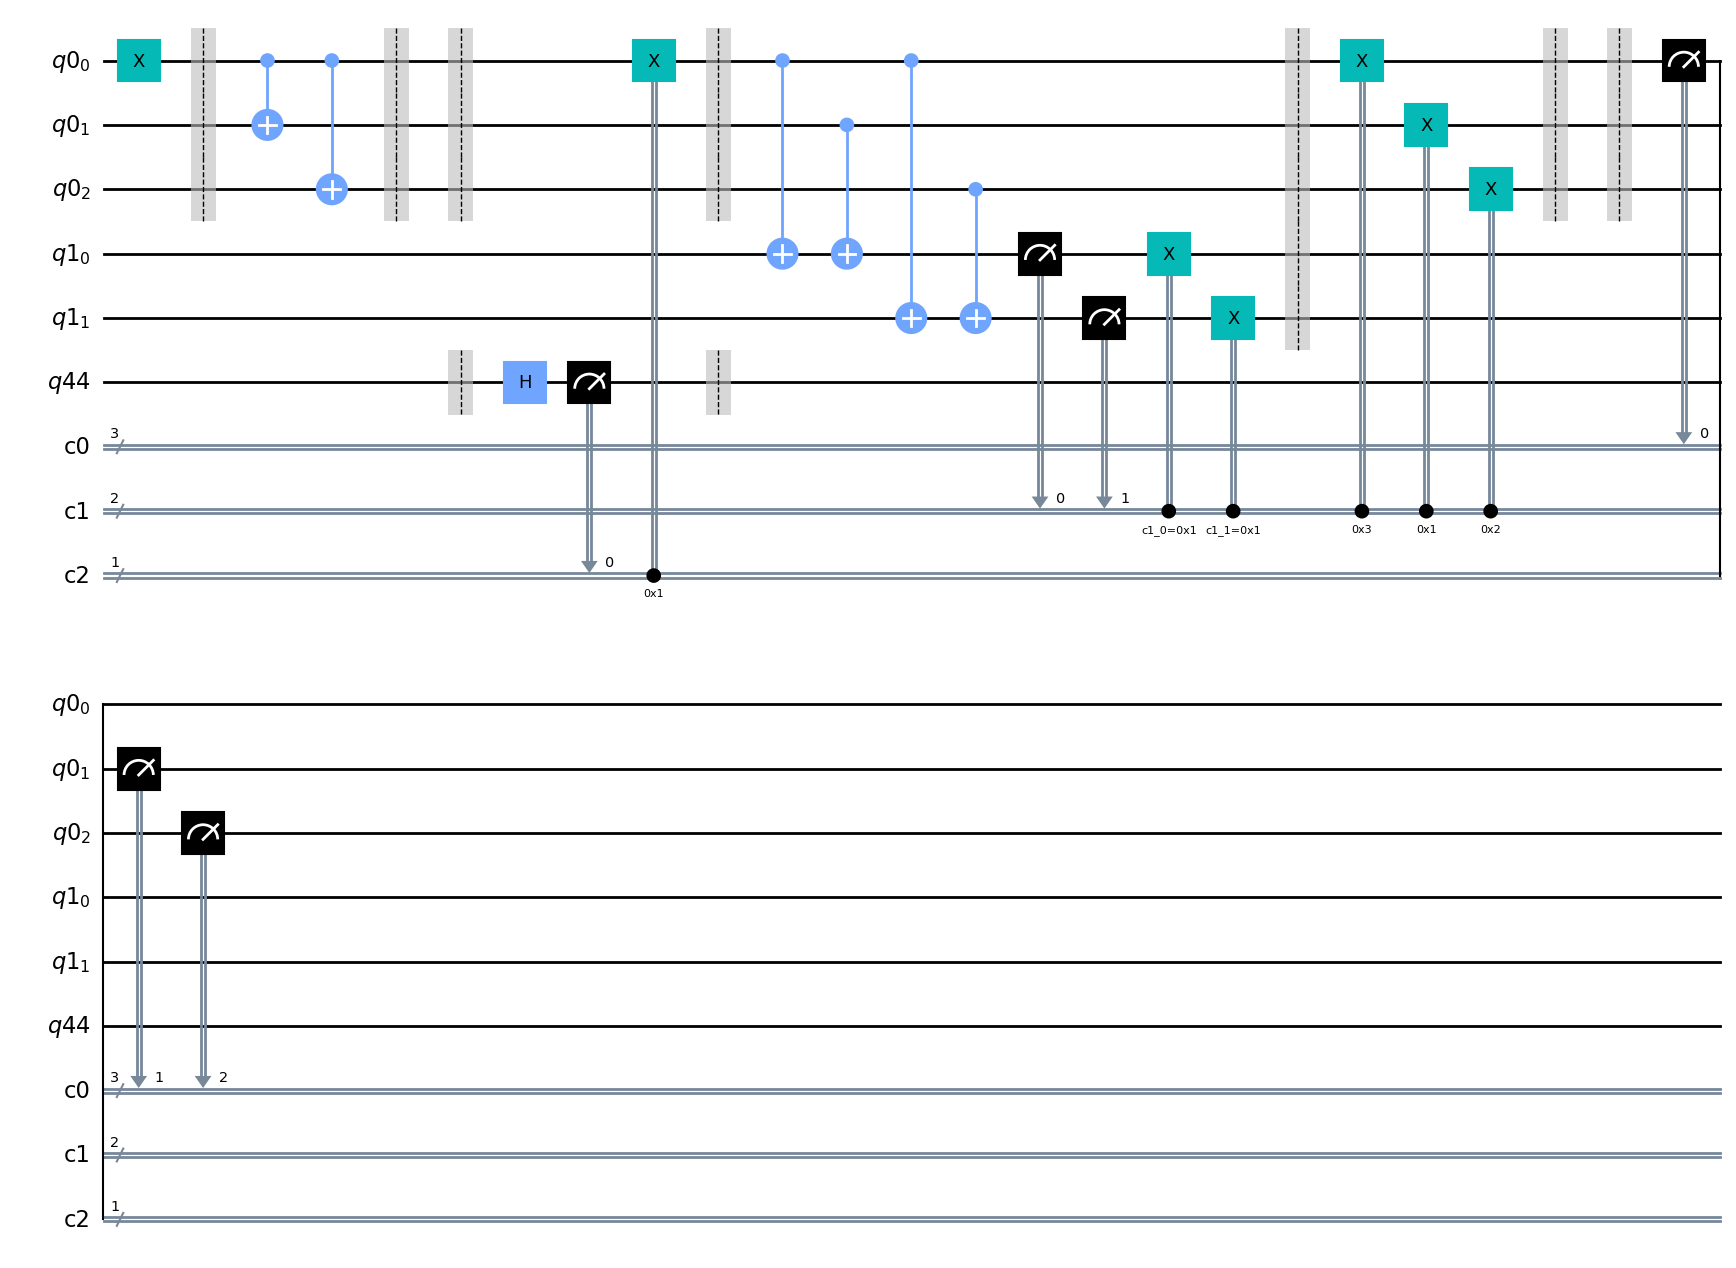

In [25]:
def build_error_channel_base():
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    return qc

qc_id_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_id_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Identity error channel"
)

qc_bit_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_bit_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Bit flip error channel"
)

qc_phase_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_phase_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Phase flip error channel"
)

circuits_error_channels_bit_flip_code = [qc_id_error_bit_flip_code, qc_bit_flip_error_bit_flip_code, qc_phase_flip_error_bit_flip_code]

qc_bit_flip_error_bit_flip_code.draw(output="mpl")

## Execute the circuits

In [26]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the most part as we are using it as a source of random information
error_channel_layout = error_channel_layout = initial_layout + list(set(range(circuits_error_channels_bit_flip_code[0].num_qubits)) - set(initial_layout))[:1]

transpiled_circuits_error_channels_bit_flip_code = apply_transpile(circuits_error_channels_bit_flip_code, backend, initial_layout=error_channel_layout)
result_error_channels_bit_flip_code = backend.run(transpiled_circuits_error_channels_bit_flip_code, dynamic=True).result()

In [27]:
def decode_error_channel_result(qc_init, data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    logical_zero = data_counts.get('000', 0)
    logical_one = data_counts.get('111', 0)
    success_trials = logical_zero + logical_one
    failed_trials = shots-success_trials
    logical_counts = {"0": logical_zero, "1": logical_one}
    
    error_correction_events = shots-syndrome_counts.get('00', 0)
    
    if verbose:
        print(f"{' ' * indent}Bit flip errors were corrected on {error_correction_events}/{shots} trials")
        print(f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials")
    return error_correction_events, failed_trials

## We see that we correct the majority of the bit flip errors introduced

In [28]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))

result_decoded_data_qubit_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, data_indices)
result_data_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, qreg_indices)
result_syndrome_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, syndrome_indices)

for i, qc in enumerate(transpiled_circuits_error_channels_bit_flip_code):
    print(f"For {qc.name} with bit flip code")
    print(f'    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_err_ch.get_counts(i)}')
    print(f'    Completed bit code experiment data qubits measurement counts {result_data_marginal_err_ch.get_counts(i)}')
    print(f'    Completed bit code experiment syndrome measurement counts {result_data_marginal_err_ch.get_counts(i)}')
    decode_error_channel_result(qc_init_outcome, result_data_marginal_err_ch.get_counts(i), result_syndrome_marginal_err_ch.get_counts(i), indent=4);
    print("")

For Identity error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 2995, '1': 1005}
    Completed bit code experiment data qubits measurement counts {'010': 504, '110': 2166, '111': 689, '011': 204, '100': 252, '000': 73, '101': 88, '001': 24}
    Completed bit code experiment syndrome measurement counts {'010': 504, '110': 2166, '111': 689, '011': 204, '100': 252, '000': 73, '101': 88, '001': 24}
    Bit flip errors were corrected on 2162/4000 trials
    A final parity error was detected on 3238/4000 trials

For Bit flip error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 2847, '1': 1153}
    Completed bit code experiment data qubits measurement counts {'000': 89, '110': 1942, '010': 569, '111': 799, '100': 247, '011': 216, '101': 106, '001': 32}
    Completed bit code experiment syndrome measurement counts {'000': 89, '110': 1942, '010': 569, '111': 799, '100': 247, '01